In [1]:
# !pip install tensorflow==2.10.0
# !pip install cv2 

In [3]:
import os
import cv2
import tensorflow as tf
from typing import List
from matplotlib import pyplot as plt
import numpy as np

In [4]:
device = tf.config.list_physical_devices('GPU')
try:
	tf.config.experimental.set_memory_growth(device[0], True)
except:
	pass

In [1]:
import zipfile

In [ ]:
if not os.path.exists("data"):
	os.makedirs("data")
      
with zipfile.ZipFile("data.zip", 'r') as zip:
    zip.extractall("data")

In [7]:
def load_vid(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [9]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [10]:
# vocab

In [11]:
chr_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_chr = tf.keras.layers.StringLookup(
    vocabulary=chr_to_num.get_vocabulary(), oov_token="", invert=True
)


In [12]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return chr_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [50]:
def load_data(path: str):
    path = tf.convert_to_tensor(path)
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_vid(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 20, 23, 15,
       39, 14, 15, 23])>

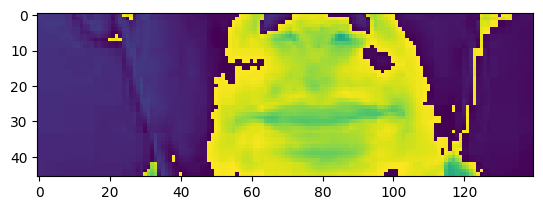

In [51]:
#load_data() is working
pathTest = './data/s1/bbaf2n.mpg'
frames, alignments = load_data(pathTest)
plt.imshow(frames[0])
alignments

In [53]:
def mappable_function(path: str) -> List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [54]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(buffer_size=tf.data.AUTOTUNE)

train, test = data.take(450),data.skip(450)

In [55]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [59]:
# !pip install pydot
# !apt-get install graphviz

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.utils import plot_model

In [61]:
#creating the neural network

model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(chr_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [62]:
# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 75, 46, 140, 128)  3584      
                                                                 
 activation_3 (Activation)   (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 75, 23, 70, 128)  0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_4 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                  

In [65]:
# model.input_shape

In [66]:
# model.output_shape

In [67]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [68]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [70]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [108]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint.weights.h5'), monitor='loss', save_weights_only=True)
schedule_callback = LearningRateScheduler(scheduler)

In [74]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback]) ####

In [ ]:
# if not os.path.exists("checkpoints"):
# 	os.makedirs("checkpoints")
      
# with zipfile.ZipFile("checkpoints.zip", 'r') as zip:
#     zip.extractall("checkpoints")

In [76]:
# model.load_weights('checkpoints/checkpoint')

**Testing on the Random Pipeline Data**

In [77]:
test_data = test.as_numpy_iterator()

In [94]:
testingData = test_data.next()

In [79]:
pdct = model.predict(testingData[0])

1/1 [==============================] - 11s 11s/step


In [80]:
decoded = tf.keras.backend.ctc_decode(pdct, input_length=[75,75], greedy=True)[0][0].numpy()

In [81]:
print("Original")
print("-"*100)
[tf.strings.reduce_join([num_to_chr(word) for word in sentence]) for sentence in testingData[1]]

Original
----------------------------------------------------------------------------------------------------


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin green with u nine again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay green in s one again'>]

In [82]:
print("Predicted")
print("-"*100)
[tf.strings.reduce_join([num_to_chr(word) for word in sentence]) for sentence in decoded]

Predicted
----------------------------------------------------------------------------------------------------


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin green with u nine again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay green in one again'>]

**Testing on video Path**

In [87]:
path = "./data/s1/bbaf2n.mpg"
adata = load_data(path)

In [92]:
pdata = adata[0]
tdata = adata[1]

In [103]:
pred = model.predict(tf.expand_dims(pdata, axis=0))
decoded = tf.keras.backend.ctc_decode(pred, input_length=[75], greedy=True)[0][0].numpy()

1/1 [==============================] - 5s 5s/step


In [100]:
print("Original")
print("-"*50)
[tf.strings.reduce_join([num_to_chr(word) for word in sentence]) for sentence in [tdata]]

Original
----------------------------------------------------------------------------------------------------


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>]

In [104]:
print("Predicted")
print("-"*50)
[tf.strings.reduce_join([num_to_chr(word) for word in sentence]) for sentence in decoded]

Predicted
----------------------------------------------------------------------------------------------------


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>]